In [1223]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [1230]:
def animate_traffic_from_start(cars, road_length, save_video=False, filename="phantom_traffic.gif"):
    start_x = []
    start_y = []
    car_colors = []
    
    track_radius = 1.0
    
    # Generate unique colors for each car
    import matplotlib.cm as cm
    colors = cm.Set3(np.linspace(0, 1, len(cars)))  # Use Set3 colormap for distinct colors

    for i, car in enumerate(cars):
        pos_0 = car["history_pos"][0]
    
        theta = (pos_0 / road_length) * (2 * np.pi)
        x = track_radius * np.cos(theta)
        y = track_radius * np.sin(theta)
        
        start_x.append(x)
        start_y.append(y)
        car_colors.append(colors[i])  # Assign unique color to each car
    
    fig, ax = plt.subplots(figsize=(6, 6))  # Smaller figure for faster rendering
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("Phantom Traffic Jam (Circular)", fontsize=15)
    
    ax.add_artist(plt.Circle((0, 0), track_radius, color='#eeeeee', fill=False, linewidth=20))

    scatter_dots = ax.scatter(start_x, start_y, s=150, c=car_colors, 
                              edgecolors='black', zorder=10)  # No colormap needed
    
    time_text = ax.text(0, 0, '0.0 s', ha='center', va='center', fontsize=14, fontweight='bold')

    def update_frame(frame_index):
        x_coords = []
        y_coords = []
        current_time = 0.0

        for car in cars:
            # Make sure we don't exceed array bounds
            if frame_index < len(car["history_pos"]):
                pos = car["history_pos"][frame_index]
                
                if car["id"] == 0: 
                    current_time = car["history_time"][frame_index]
            else:
                # Use last available data point
                pos = car["history_pos"][-1]
                if car["id"] == 0:
                    current_time = car["history_time"][-1]

            theta = (pos / road_length) * (2 * np.pi)
            x = track_radius * np.cos(theta)
            y = track_radius * np.sin(theta)
            
            x_coords.append(x)
            y_coords.append(y)
            
        # Update scatter plot positions only (colors stay fixed)
        scatter_dots.set_offsets(np.c_[x_coords, y_coords])
        time_text.set_text(f'{current_time:.1f} s')
        
        return [scatter_dots, time_text]

    total_frames = len(cars[0]["history_pos"])
    skip = 3  # Optimal skip for smooth animation
    
    ani = FuncAnimation(fig, update_frame, frames=range(0, total_frames, skip), 
                        interval=80, blit=False, repeat=True)  # Optimal timing

    if save_video:
        
        try:
            # Use pillow writer for optimized GIF creation
            ani.save(filename, writer='pillow', fps=15, dpi=80)  # Higher quality, good speed
        except Exception as e:
            print(f"Failed to save GIF: {e}")
    else:
        plt.show()
    
    return ani

def save_traffic_gif(cars, road_length, filename="traffic_simulation.gif"):
    return animate_traffic_from_start(cars, road_length, save_video=True, filename=filename)

# How We Simulate Traffic and Why Jams Happen

## 1. Predicting the Future (Solving ODEs with Euler's Method)
We use simple physics formulas in the code, like:
*   `velocity = velocity + acceleration * time`
*   `position = position + velocity * time`

**This IS solving Ordinary Differential Equations (ODEs)!**

The mathematical definitions are:
$$ \frac{dx}{dt} = v \quad \text{(Change in position is speed)} $$
$$ \frac{dv}{dt} = a \quad \text{(Change in speed is acceleration)} $$

In computer simulations, we cannot calculate "continuous" change. Instead, we use a technique called **Euler's Method** to solve these ODEs step-by-step. We take the current state and move it forward by a tiny time step ($h$).

## 2. The Driver's Brain (IDM Model)
We give every simulated car a "brain" called the **Intelligent Driver Model (IDM)**. It calculates the acceleration ($a$) using this formula:

$$ a = a_{max} \left[ 1 - \left( \frac{v}{v_0} \right)^\delta - \left( \frac{s^*}{s} \right)^2 \right] $$

### What do the symbols mean?
*   **$a$ (Acceleration):** How much the driver presses the gas pedal (positive) or brake pedal (negative).
*   **$a_{max}$ (Max Acceleration):** The maximum power of the car's engine.
*   **$v$ (Current Speed):** How fast the car is going right now.
*   **$v_0$ (Desired Speed):** The speed limit or how fast the driver *wants* to go.
*   **$\delta$ (Delta):** How aggressively the driver accelerates when the road is open.
*   **$s$ (Actual Gap):** The real distance to the car in front.
*   **$s^*$ (Desired Gap):** The safe distance the driver *wants* to keep. If the real gap ($s$) is smaller than this ($s^*$), the driver brakes.

## 3. Why Phantom Jams Happen
A "phantom jam" is when traffic stops for no apparent reason (no accidents or roadworks).

In our model, this happens **only when drivers are aggressive**.
*   **Aggressive Behavior:** Driving fast, braking hard, and following too closely.
*   **The Chain Reaction:** If one aggressive driver taps the brakes, the car behind them panics and brakes harder. The next car brakes even harder.
*   **Result:** This "wave" of braking travels backward, eventually causing cars miles behind to come to a complete stop.

**Conclusion:** If drivers are calm and keep a safe distance, traffic flows smoothly. If they are aggressive, phantom jams appear.

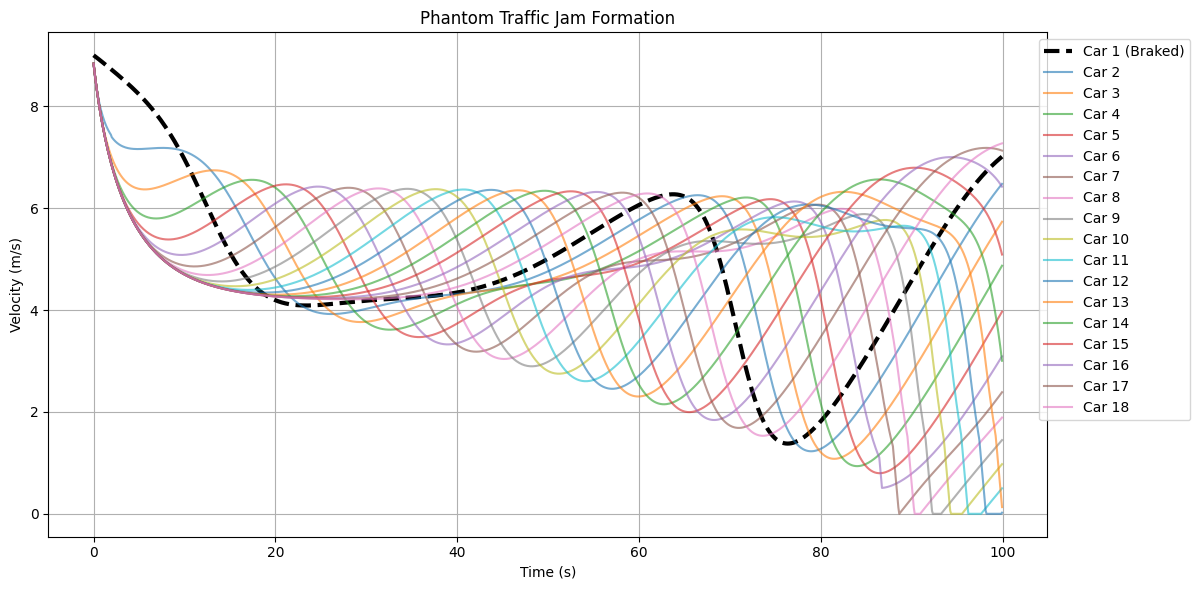

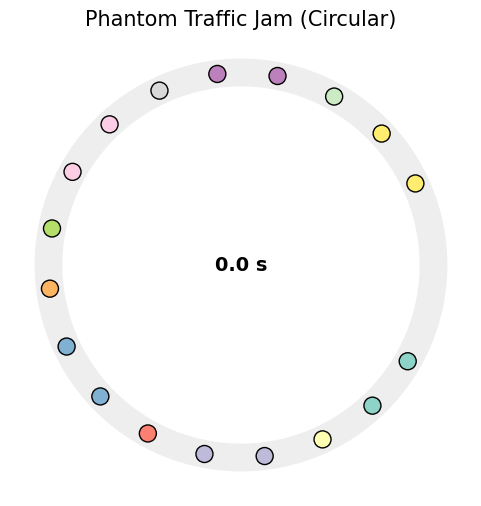

In [ ]:
# for car
def create_car(car_id, position, velocity):
    return {
        "id": car_id,
        "position": position,
        "velocity": velocity,
        "history_time": [],
        "history_vel": [],
        "history_pos": []
    }

def log_car_state(car, time):
    car["history_time"].append(time)
    car["history_vel"].append(car["velocity"])
    car["history_pos"].append(car["position"])

def generate_car(total_car, velocity):
    cars = []
    for i in range(total_car, 0, -1):
        pos = i * 15 + 5  
        car = create_car(total_car - i, pos, velocity)
        cars.append(car)
    return cars

# Adjusted IDM parameters for more aggressive stopping behavior
T = 2.0          # time gap for driver to maintains to car ahead
A_MAX = 0.5      # how hard he press the gas
B_COMF = 3.0     # how hard he brake
DELTA = 6        # higher = more sensitive
S0 = 3.0         # minimum gap before collision
ROAD_LEN = 300.0  
MAX_BRAKING = -8.0 # Strong braking capability

# find the best acceleration via model 
def get_idm_acceleration(current_car, front_car, desired_velocity):
    cur_vel = current_car["velocity"]
    front_vel = front_car["velocity"]
    
    gap_vel = cur_vel - front_vel
    gap_pos = front_car["position"] - current_car["position"]


    if gap_pos < 0:
        gap_pos += ROAD_LEN
    
    # IDM desired spacing: s* = s₀ + vT + (vΔv)/(2√ab)
    s_star = S0 + max(0, cur_vel * T + (cur_vel * gap_vel) / (2 * np.sqrt(A_MAX * B_COMF)))
    
    safe_gap = max(gap_pos - 4.0, 0.1)
    
    velocity_term = (cur_vel / desired_velocity) ** DELTA  # Speed limiting term
    gap_term = (s_star / safe_gap) ** 2                    # Gap control term

    # IDM acceleration formula: a = a_max[1 - (v/v₀)^δ - (s*/s)²]
    acc = A_MAX * (1 - velocity_term - gap_term)
    
    if gap_pos < 8.0:  
        acc = min(acc, -2.0)
    
    if gap_pos < 5.0:
        acc = MAX_BRAKING   
    
    acc = max(min(acc, A_MAX), MAX_BRAKING)
    return acc
    

def run_simulate_and_save_video(total_car, max_velocity, time_bound, h, video_filename="phantom_traffic.mp4"):
    # generate car
    cars = generate_car(total_car, max_velocity)    

    steps = int(time_bound / h)
    current_time = 0.0

    first_car_id = 0

    for _ in range(steps):    
        for i in range(len(cars)):
            front_car = cars[i]
            cur_car = cars[(i + 1)% total_car]

            if (0 < current_time - 2 < 0.01 and i == 0):
                cur_car["velocity"] -= 0.5 * h
                cur_car["position"] += cars[first_car_id]["velocity"] * h
                log_car_state(cars[i], current_time)
                continue
        
            
            log_car_state(cars[i], current_time)

            # Get safe acceleration
            safe_acc = get_idm_acceleration(cur_car, front_car, max_velocity)

            # Update Velocity: v = v + at
            cur_car["velocity"] += safe_acc * h
            if cur_car["velocity"] > max_velocity:
                cur_car["velocity"] = max_velocity
            if cur_car["velocity"] < 0: 
                cur_car["velocity"] = 0 

            # Update Position: x = x + vt
            cur_car["position"] += cur_car["velocity"] * h
            
            if cur_car["position"] >= ROAD_LEN:
                cur_car["position"] -= ROAD_LEN
        
        current_time += h

    # Show velocity plot
    plt.figure(figsize=(12, 6))
    for car in cars:
        if car["id"] == first_car_id:
            plt.plot(car["history_time"], car["history_vel"], label=f'Car {car["id"]+1} (Braked)', linewidth=3, color='black', linestyle='--')
        else:
            plt.plot(car["history_time"], car["history_vel"], label=f'Car {car["id"]+1}', alpha=0.6)
    
    plt.title("Phantom Traffic Jam Formation")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    global_anim = save_traffic_gif(cars, ROAD_LEN, video_filename)
    return global_anim

run_simulate_and_save_video(18, 9, 100, 0.1, "phantom_traffic.gif")